<p align="center">
  <br/>
    <img alt="ScaleDP" src="https://stabrise.com/media/filer_public_thumbnails/filer_public/4a/7d/4a7d97c2-50d7-4b7a-9902-af2df9b574da/scaledplogo.png__1000x300_subsampling-2.webp" width="376" style="max-width: 100%;">
  <br/>
</p>

<p align="center">
    <a target="_blank" href="https://colab.research.google.com/github/StabRise/scaledp-tutorials/blob/master/3.Ner.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://github.com/stabrise/scaledp/" alt="GitHub"><img src="https://img.shields.io/static/v1?label=GitHub&message=ScaleDP&color=blue&logo=github" /></a>
    <a href="https://pypi.org/project/scaledp/" alt="Package on PyPI"><img src="https://img.shields.io/pypi/v/scaledp.svg" /></a>    
    <a href="https://github.com/stabrise/scaledp/blob/main/LICENSE"><img alt="GitHub" src="https://img.shields.io/github/license/stabrise/scaledp.svg?color=blue"></a>
    <a href="https://stabrise.com"><img alt="StabRise" src="https://img.shields.io/badge/by-StabRise-orange.svg?style=flat&colorA=E1523D&colorB=007D8A"></a>
</p>

# Named Entity Recognition (NER) with Spark Pdf

Spark Pdf provides possibility to run NER models using HugeTransformer library. You can run NER models for text and pdf documents.
You can use any NER models from the Hugging Face model hub. You can also visualize the results of the NER models.

## Installation

In [ ]:
%%bash
[[ ! "${COLAB_RELEASE_TAG}" ]] && exit
sudo apt install tesseract-ocr

In [ ]:
!pip install scaledp[ml]

## Start Spark Session with ScaleDP

In [1]:
from scaledp import *
import os

os.environ["OPENAI_API_KEY"] = "your_key"
os.environ["OPENAI_BASE_URL"] = 'https://generativelanguage.googleapis.com/v1beta/'

spark = ScaleDPSession()
spark

/home/mykola/.cache/pypoetry/virtualenvs/scaledp-P-kXHL64-py3.12/lib/python3.12/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
25/03/08 09:07:17 WARN Utils: Your hostname, mykola-ROG-Strix-G634JY-G634JY resolves to a loopback address: 127.0.1.1; using 192.168.1.117 instead (on interface wlo1)
25/03/08 09:07:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/08 09:07:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Read Text

In [2]:
df = spark.read.text("./data/texts/example.txt", wholetext=True)
df.show(1, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Show text

In [3]:
df.show_text()

Id:,0


## Run Ner for Text document

In [4]:
pipeline = PipelineModel(stages=[
    TextToDocument(),
    LLMNer()
])
result = pipeline.transform(df).cache()

result.show_ner("ner")

+------------+-----+-------------------+-----+---+-----+
|entity_group|score|               word|start|end|boxes|
+------------+-----+-------------------+-----+---+-----+
|ORGANIZATION|  0.0|             OpenAI|    0|  0|   []|
|ORGANIZATION|  0.0|Stanford University|    0|  0|   []|
|ORGANIZATION|  0.0|                MIT|    0|  0|   []|
|ORGANIZATION|  0.0|          Microsoft|    0|  0|   []|
|ORGANIZATION|  0.0|             Amazon|    0|  0|   []|
|ORGANIZATION|  0.0|             Google|    0|  0|   []|
|ORGANIZATION|  0.0| Harvard University|    0|  0|   []|
|      PERSON|  0.0|         Sam Altman|    0|  0|   []|
|      PERSON|  0.0|      Sundar Pichai|    0|  0|   []|
|      PERSON|  0.0|     Dr. Jane Smith|    0|  0|   []|
|    LOCATION|  0.0|      San Francisco|    0|  0|   []|
|        DATE|  0.0|   October 21, 2024|    0|  0|   []|
|  PERCENTAGE|  0.0|                 2%|    0|  0|   []|
+------------+-----+-------------------+-----+---+-----+



# Run Ner for Pdf document

## Read Pdf file

Image#:,0
Path:,example.pdf
Size:,2484 x 3509 px
Resolution:,300 dpi

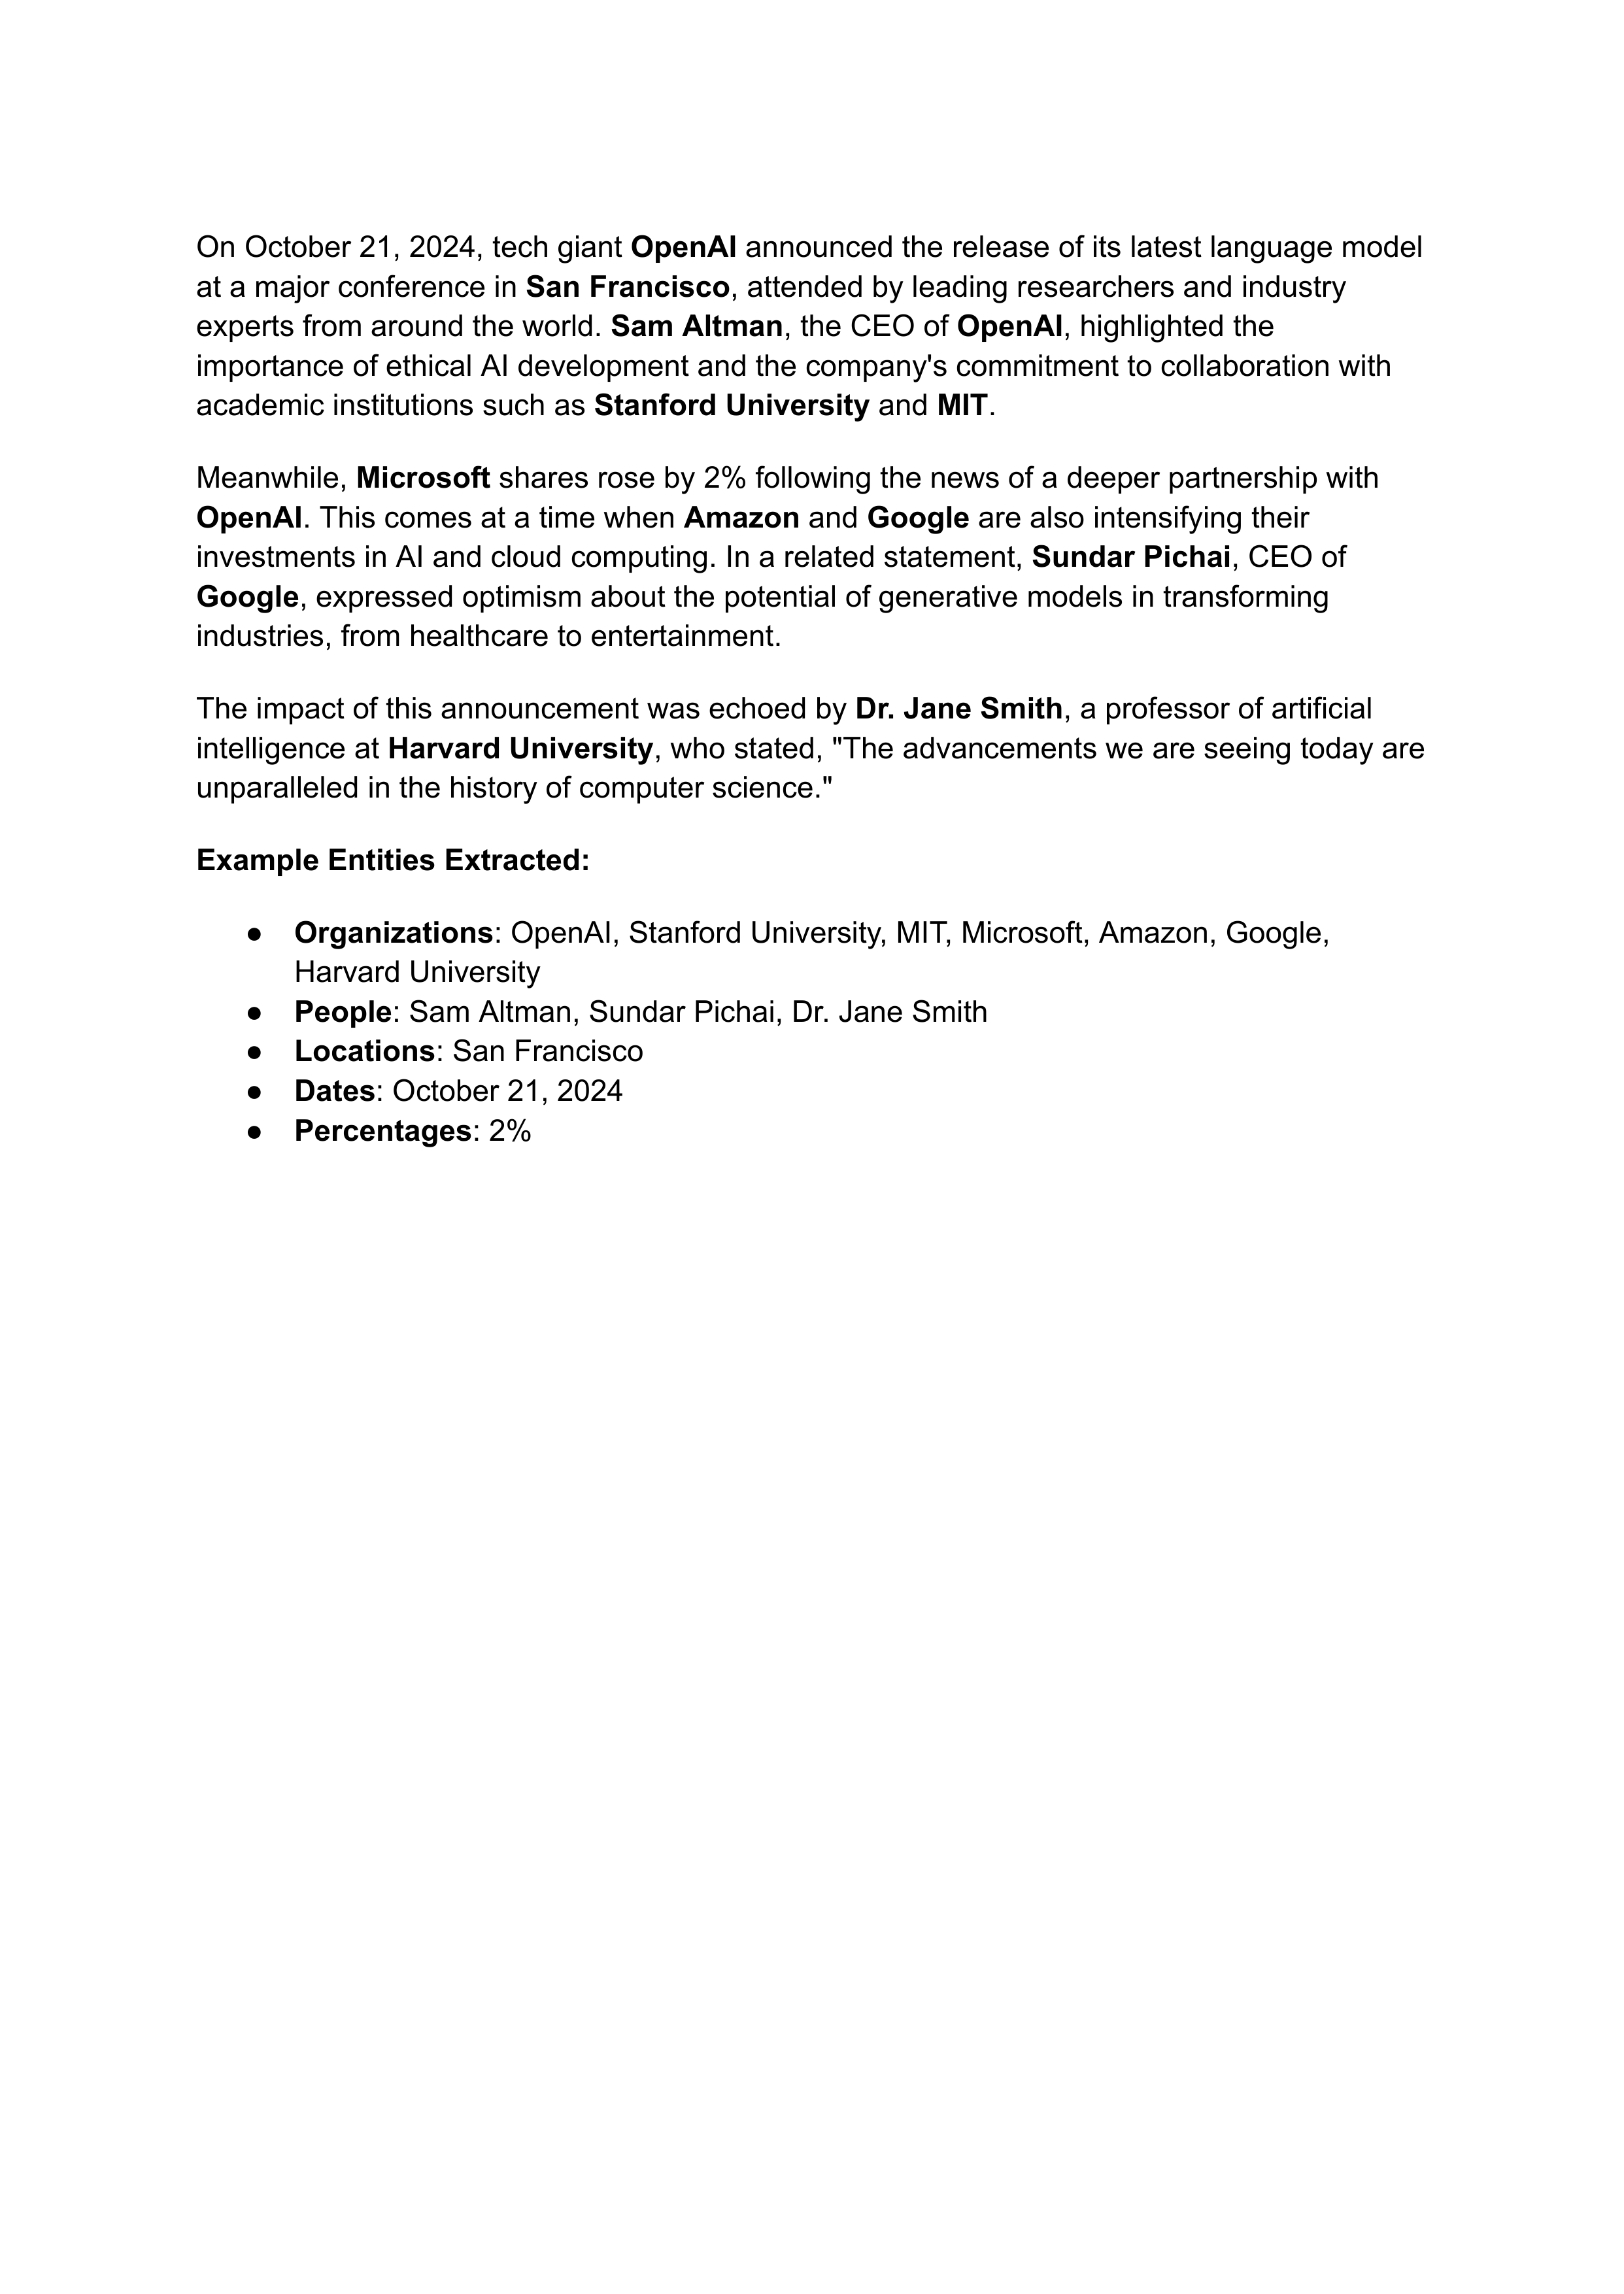

In [6]:
pdf_df = spark.read.format("binaryFile").load("./data/pdfs/example.pdf")

pdf_df.show_pdf()

## Run Ner for Pdf document

In [9]:
pipeline = PipelineModel(stages=[
    PdfDataToImage(),
    TesseractOcr(keepInputData=True),
    LLMNer(model="gemini-1.5-flash-8b"),
    ImageDrawBoxes(inputCols=["image", "ner"], displayDataList=["entity_group", "score"],
                   textSize=20, lineWidth=3)
])

result = pipeline.transform(pdf_df).cache()

result.show_ner("ner")

+------------+-----+-------------------+-----+---+--------------------+
|entity_group|score|               word|start|end|               boxes|
+------------+-----+-------------------+-----+---+--------------------+
|ORGANIZATION|  0.0|             OpenAl|    0|  0|[{OpenAl, 0.90458...|
|ORGANIZATION|  0.0|Stanford University|    0|  0|[{Stanford, 0.961...|
|ORGANIZATION|  0.0|                MIT|    0|  0|[{commitment, 0.9...|
|ORGANIZATION|  0.0|          Microsoft|    0|  0|[{Microsoft, 0.96...|
|ORGANIZATION|  0.0|             Amazon|    0|  0|[{Amazon, 0.96318...|
|ORGANIZATION|  0.0|             Google|    0|  0|[{Google, 0.96318...|
|ORGANIZATION|  0.0| Harvard University|    0|  0|[{University, 0.9...|
|      PERSON|  0.0|         Sam Altman|    0|  0|[{Sam, 0.96336723...|
|      PERSON|  0.0|      Sundar Pichai|    0|  0|[{Sundar, 0.93134...|
|      PERSON|  0.0|     Dr. Jane Smith|    0|  0|[{Dr., 0.96413405...|
|    LOCATION|  0.0|      San Francisco|    0|  0|[{San, 0.95797

## Visualize Ner results on original image

Image#:,0
Path:,example.pdf
Size:,2484 x 3509 px
Resolution:,300 dpi

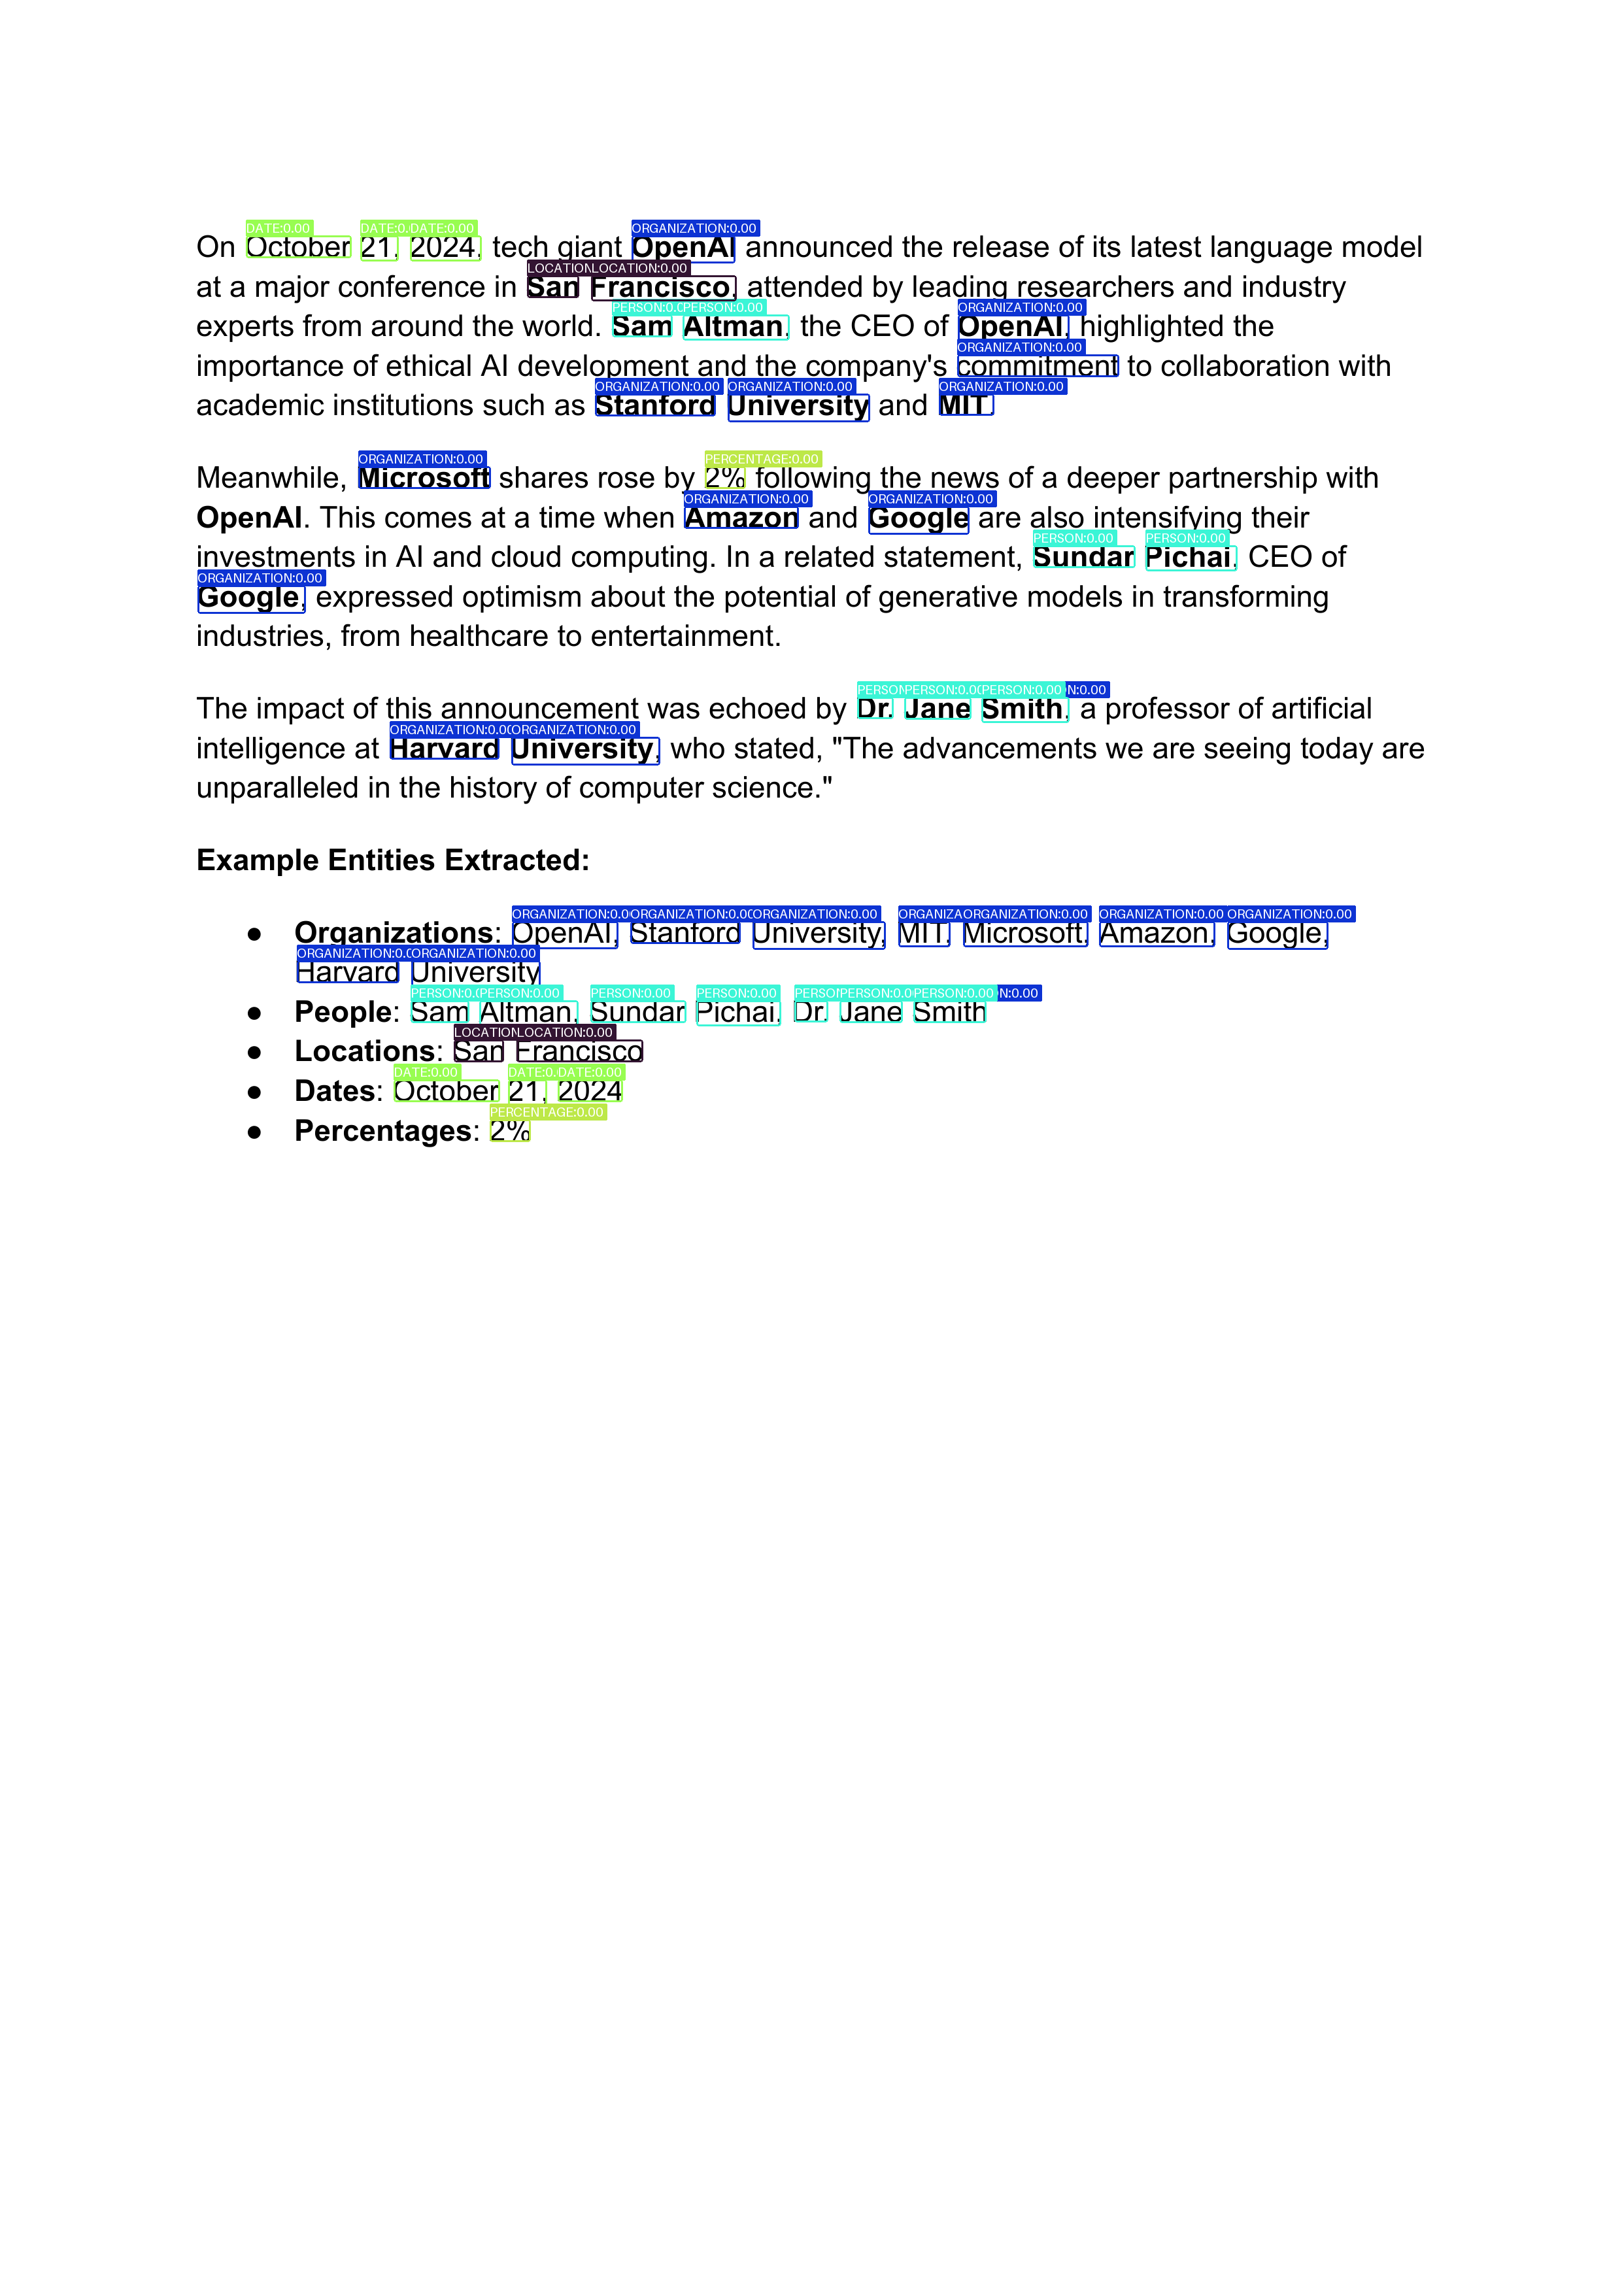

In [10]:
result.show_image("image_with_boxes")